### Description
This is skeleton code for **Exercise 2: Regression** for *L335 Machine Visual Perception*. For this task, we will take advantage of Implicit Neural Representations (INR), an alternative way to represent signals such as images, videos and 3D volumes. This exercise is limited to RGB images to accommodate easy experimenting.

The basic idea is simple. We aim to learn a mapping $f$ between spatial coordinates ($x, y$ for a 2D image) and the corresponding RGB pixel values:
$$ (r, g, b) = f(x, y) = f(\mathbf g),$$

where $\mathbf g$ is a 2D grid coordinate. Note how this is different to directly storing all RGB values in a spatial grid. We will approximate $f$ with a neural network and fit it for an example image. For an image with height $h$ and width $w$, we have $h \times w$ training samples for our supervised regression problem.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

First, run the rest of this file without any changes as a sanity check.

In [1]:
import torch, torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import trange
import gdown
import math

# !pip install torchmetrics
import torchmetrics

/home/bad35/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Read the example image and normalise pixel values to the range [0, 1]. Also set up the coordinate input to the network.

In [2]:
!gdown https://drive.google.com/uc?id=1KQCp48jXxlioyL6eYf9pfD-BkZyHvg5s
filename = 'kings_chapel.jpg'
img = torchvision.io.read_image(filename) / 255
_, h, w = img.shape
img = img.permute(1,2,0).reshape(-1, 3)

tensors = (torch.linspace(-1, 1, steps=h), torch.linspace(-1, 1, steps=w))
coord_grid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1).reshape(-1, 2)

Downloading...
From: https://drive.google.com/uc?id=1KQCp48jXxlioyL6eYf9pfD-BkZyHvg5s
To: /home/bad35/kings_chapel.jpg
100%|████████████████████████████████████████| 271k/271k [00:00<00:00, 4.36MB/s]


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # Update this line if you want to use a different device such as TPU or Macbook's MPS
print(f'Using {device} device')
if device == 'cuda':
    print(torch.cuda.get_device_name())

Using cuda device
Tesla P100-PCIE-16GB


Start with a simple MLP. It should have 2 inputs (corresponding to spatial locations $x, y$) and 3 outputs. We will use 3 hidden layers with 256 neurons each.

In [4]:
class IRN(nn.Module):
    def __init__(self, positional_encoding=False, n_hidden=256):
        super(IRN, self).__init__()
        self.positional_encoding = positional_encoding
        n_in = 2
        n_out = 3
        self.layer_in = nn.Linear(n_in, n_hidden)
        self.layer_hidden = nn.Linear(n_hidden, n_hidden)
        self.layer_out = nn.Linear(n_hidden, n_out)
        self.activation = nn.ReLU()

    def forward(self, x):
        if self.positional_encoding:
            x = self.positional_encoding_function(x)
        x = self.activation(self.layer_in(x))
        x = self.activation(self.layer_hidden(x))
        x = self.activation(self.layer_out(x))
        return x

    def positional_encoding_function(self, x):
        # Add code for Task 2
        # Remember to also update the input layer
        pass

Train the IRN. Each training iteration involves predicting the entire image before computing loss. Note that this is not necessary, it is possible to work with a just a few samples if needed.

Loss=0.0300: 100%|████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.39it/s]


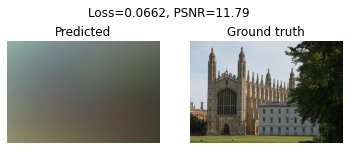

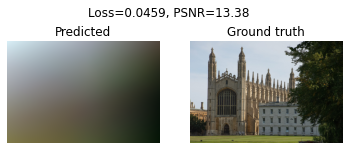

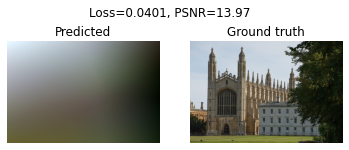

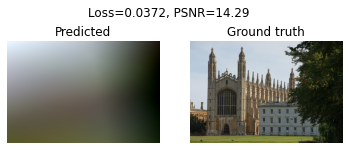

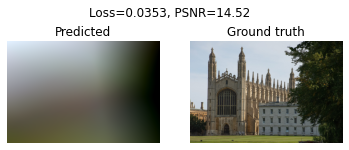

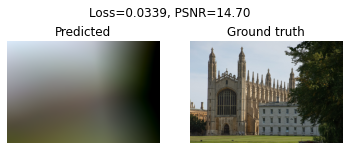

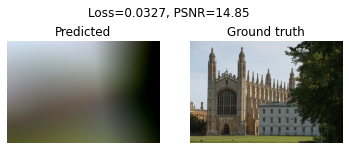

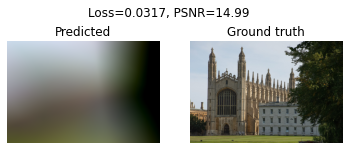

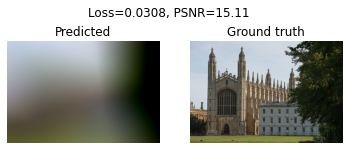

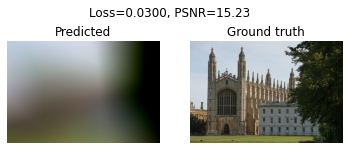

In [5]:
irn = IRN().to(device)

img, coord_grid = img.to(device), coord_grid.to(device)

num_steps = 400
lr = 1e-4
opt = torch.optim.Adam(lr=lr, params=irn.parameters())
psnr_fn = torchmetrics.image.PeakSignalNoiseRatio(data_range=1)
psnr_fn.to(device)

torch.manual_seed(0)

pbar = trange(num_steps)
for step in pbar:
    opt.zero_grad()
    img_hat = irn(coord_grid)
    loss = ((img - img_hat)**2).mean()
    loss.backward()
    opt.step()
    pbar.set_description(f'Loss={loss.item():0.4f}')

    if (step + 1) % (num_steps//10) == 0:
        with torch.no_grad():
            psnr = psnr_fn(img_hat, img)
            fig, ax = plt.subplots(1, 2)
            fig.suptitle(f'Loss={loss.item():0.4f}, PSNR={psnr:0.2f}', y=0.8)
            ax[0].imshow(irn(coord_grid).clip(0, 1).cpu().reshape(h, w, 3))
            ax[0].set_title('Predicted')
            ax[0].axis('off')
            ax[1].imshow(img.cpu().reshape(h, w, 3))
            ax[1].set_title('Ground truth')
            ax[1].axis('off')

If the run completed successfully, you should see a blurry output similar to this:

![Naive result](https://drive.google.com/uc?export=view&id=1xHUdQSOtd7UITz0T37m5oT45qEhB-d-z)

### Task 1
Change the global seed (line 1 in the training code block) to 1 and retrain the network. This results in a significantly poorer reconstruction. Changing the seed results in a different initial configuration of the weights. In fact, most seeds result in poor convergence. Can you identify a network initialization function that results in PSNR > 15 regardless of the seed chosen?

*Constraints:* For this task, you are **not allowed** to change
1. Number of training epochs
2. Network size
3. Optimizer (or its parameters such as learning reta, betas)

**Deliverable:** Quantitative comparison showing the effect of different functions for initialising weights. Use the PSNR metric for all tables and plots.

In [16]:
# Add code for Task 1

# reset all model weights. With linear layers, this resets weights uniformly between ±(in_features)^(-1/2) (see: https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)
def reset_model_parameters(model, printout=True):
    if printout:
        print('Resetting using `reset_parameters`...')
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            if printout:
                print('reset',layer)

# reset parameters using normal distribution
def normal_reset(model, bias=False, type=None):
    match type:
        case None:
            print('Resetting using standard normal...')
        case 'kaiming':
            print('Resetting using Kaiming normal...')
        case 'xavier':
            print('Resetting using Xavier normal...')
        case _:
            raise Exception('Invalid normal initializer type:', type)
    
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'): # this is a proxy to get the layers. Probably better ways to do this though
            match type:
                case None:
                    nn.init.normal_(layer.weight)
                case 'kaiming':
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                case 'xavier':
                    nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('relu'))

            if bias:
                nn.init.normal_(layer.bias)
            print('reset',layer)

# reset parameters using uniform distribution
def uniform_reset(model, bias=False, type=None, bound=1):
    match type:
        case None:
            print('Resetting using standard uniform...')
        case 'kaiming':
            print('Resetting using Kaiming uniform...')
        case 'xavier':
            print('Resetting using Xavier uniform...')
        case _:
            raise Exception('Invalid uniform initializer type:', type)
    
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            match type:
                case None:
                    nn.init.uniform_(layer.weight, -bound, bound)
                case 'kaiming':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                case 'xavier':
                    nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))

            if bias:
                nn.init.uniform_(layer.bias, -bound, bound)
            print('reset',layer)

# reset parameters all to zero
def zeros_reset(model, bias=False):
    print('Resetting to zeros...')
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            nn.init.zeros_(layer.weight)
            if bias:
                nn.init.zeros_(layer.bias)
            print('reset',layer)

# reset parameters all to one
def ones_reset(model, bias=False):
    print('Resetting to ones...')
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            nn.init.ones_(layer.weight)
            if bias:
                nn.init.ones_(layer.bias)
            print('reset',layer)

In [17]:
initializers = {
    reset_model_parameters: [
        dict()
    ],
    normal_reset: [
        dict(),
        dict(type='kaiming'),
        dict(type='xavier')
    ],
    uniform_reset: [
        dict(),
        dict(type='kaiming'),
        dict(type='xavier')
    ]
    # zeros_reset: [dict()],
    # ones_reset: [dict()]
}

In [18]:
img, coord_grid = img.to(device), coord_grid.to(device)

epochs = 400
lr = 1e-4
psnr_fn = torchmetrics.image.PeakSignalNoiseRatio(data_range=1).to(device)
opt = torch.optim.Adam(lr=lr, params=irn.parameters())

In [19]:
torch.seed()

for init_fn, init_params in initializers.items():
    for init_kwargs in init_params:
        reset_model_parameters(irn, printout=False)
        init_fn(irn, **init_kwargs)

        pbar = trange(epochs)
        for epoch in pbar:
            opt.zero_grad()
            img_hat = irn(coord_grid)
            loss = ((img - img_hat)**2).mean()
            loss.backward()
            opt.step()
            pbar.set_description(f'Loss={loss.item():0.4f}')
        
        with torch.no_grad():
            psnr = psnr_fn(img_hat, img)
            fig, ax = plt.subplots(1, 2)
            fig.suptitle(f'Loss={loss.item():0.4f}, PSNR={psnr:0.2f}', y=0.8)
            ax[0].imshow(irn(coord_grid).clip(0, 1).cpu().reshape(h, w, 3))
            ax[0].set_title('Predicted')
            ax[0].axis('off')
            ax[1].imshow(img.cpu().reshape(h, w, 3))
            ax[1].set_title('Ground truth')
            ax[1].axis('off')
            
            plt.show()

Resetting using `reset_parameters`...
reset Linear(in_features=2, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0371:  42%|████████████████████████████▉                                       | 170/400 [00:21<00:28,  7.96it/s]


KeyboardInterrupt: 

### Task 2
Experiment with different architectures (deeper or wider networks), different reconstruction losses (L1, Huber) and optimizers. Report your results, again with quantitative metrics. Check if your design choices are consistent for different inputs with possibly different resolutions.

You will notice that the network is unable to fit the image properly because it is limited by the number of input dimensions. You can fix this by *Fourier feature mapping* — by passing the input 2D coordinates through a Positional Encoding function [1] — to better learn high-frequencies in the image.

[1] Tancik, Matthew, et al. "Fourier features let networks learn high frequency functions in low dimensional domains." Advances in Neural Information Processing Systems 33 (2020): 7537-7547. Link: https://proceedings.neurips.cc/paper/2020/hash/55053683268957697aa39fba6f231c68-Abstract.html

Specifically, you will implement the Gaussian Fourier feature mapping: $\gamma(\mathbf{g})= \left[ \cos(2 \pi \mathbf B \mathbf{g}), \sin(2 \pi \mathbf B \mathbf{g}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times 2}$ is sampled from $\mathcal N(0,\sigma^2)$. Here, $m$ is the number of normally distributed sinosoidal frequencies and $\mathbf g = (x, y)$ is an input 2D coordinate.

The Fourier feature mapping $\gamma(\mathbf g)$ thus provides a $2 \times m$ input to the MLP. In place of the direct mapping, we learn
$$(r, g, b) = f(\gamma(\mathbf g)).$$

**Deliverable:** Demonstrate the effectiveness of FFN on own your set of diverse images. Different images will benefit from a different choice of $\sigma$ (standard deviation of frequencies). Show the result of fitting an INR with FFN for an image composed of lower frequencies (such as sky) as well as an image with high frequencies (such as grass).

### Task 3
The neural network approximates a continuous signal and can be queried at arbitrary resolutions. Your final task is to produce a 4x upsampled image by providing a denser input grid to the network. Recall that the grid coordinates are rescaled to the range $[0,1]$.